# Setup

## Imports

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pandas_profiling
import numpy as np

import sklearn

from IPython.display import display
import pandas_profiling
# do not use %pylab, that inserts packages into the namespace 
%matplotlib inline

/home/sam/.local/bin/miniconda3/envs/sci/lib/python3.6/site-packages/pandas_profiling/plot.py:15: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/sam/.local/bin/miniconda3/envs/sci/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/sam/.local/bin/miniconda3/envs/sci/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/sam/.local/bin/miniconda3/envs/sci/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/sam/.local/bin/miniconda3/envs/sci/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/h

## Helper methods

In [2]:
def fix_layout(width:int=95):
    from IPython.core.display import display, HTML
    display(HTML('<style>.container { width:' + str(width) + '% !important; }</style>'))
    
fix_layout()


def group_and_count(df, groupby_column, with_pct=False, with_avg=False):
    result = df.groupby(groupby_column).size().sort_values(ascending=False).reset_index().rename(columns={0: 'count'})
    if with_pct:
        result['count_pct'] = result['count'] / result['count'].sum()
    if with_avg:
        result['count_avg'] = result['count'].mean()
    return result

In [3]:
from operator import itemgetter 

def plot_feature_importance(feature_importances,
                            column_names,
                            top=None,
                            min_imp_coverage=None):
    
    feature_importance = sorted(zip(column_names, feature_importances), key=itemgetter(1), reverse=True)
    nb_feats = len(feature_importance)
    plt.figure(figsize=(5, np.ceil(nb_feats * 0.35)))
    plt.barh(-1 * np.arange(nb_feats), [item[1] for item in feature_importance]) #, color=bar_colours)
    plt.yticks(-1 * np.arange(nb_feats) + 0.5, [item[0] for item in feature_importance], rotation=0)
    plt.ylim(ymin=-nb_feats - 1, ymax=1)

    title_str = 'Feature Importances'
    if top is not None:
        title_str = title_str + ' of top {0:d} features'.format(top)
    if min_imp_coverage is not None:
        title_str = title_str + ' of features with combined importance coverage of >= {0:.0%}'.format(min_imp_coverage)
    plt.title(title_str)

    return feature_importance

In [4]:
from sklearn.metrics import confusion_matrix
    
def plot_confusion_matrix(y_true, y_pred, class_labels=None, title='', cmap=plt.cm.Blues):

    class_labels = class_labels or [0,1]

    cm = confusion_matrix(y_true, y_pred)

    fig = plt.figure()
    ax = fig.add_subplot(111)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.colorbar()
    ax.set_xticks(np.arange(cm.shape[0]))
    ax.set_yticks(np.arange(cm.shape[1]))
    ax.set_xticklabels(list(class_labels), rotation=0)
    ax.set_yticklabels(list(class_labels))
    plt.tight_layout()
    plt.xlabel('Predicted class')
    plt.ylabel('True class')
    plt.title(title)
    ax.tick_params(axis='both', which='both', length=0)

    width, height = cm.shape

    colour_threshold = np.amax(cm) / 2

    for x in range(width):
        for y in range(height):
            if cm[x][y] > 0:
                if cm[x][y] > colour_threshold:
                    color = 'white'
                else:
                    color = 'black'

                ax.text(y,
                        x,
                        str(cm[x][y]),
                        verticalalignment='center',
                        horizontalalignment='center',
                        color=color,
                        fontsize=15)

In [5]:
def distribution_comparison_plot(df, compare_col, idx, idx_label=None, cap_quantile=None, floor_quantile=None):
    def remove_nans(values):
        idx = np.isnan(values)
        return values[~idx], idx.sum()

    [floor, cap] = np.percentile(df.loc[df[compare_col].notnull(), compare_col],
                                 [floor_quantile or 0, cap_quantile or 100])
    idx_floor_cap = (df[compare_col] >= floor) & (df[compare_col] <= cap)

    values_idx_true, nb_nans_idx_true = remove_nans(df.loc[idx & idx_floor_cap, compare_col])
    values_idx_false, nb_nans_idx_false = remove_nans(df.loc[~idx & idx_floor_cap, compare_col])

    plt.figure()
    if len(np.unique(values_idx_true)) > 1:
        sns.distplot(values_idx_true, label=(idx_label or 'Index') + ': True')
    if len(np.unique(values_idx_false)) > 1:
        sns.distplot(values_idx_false, label=(idx_label or 'Index') + ': False')
    plt.legend()
    plt.title('distribution comparison plot\n(removed {0} nan from the "True" dist and {1} from the "False" dist)'
              .format(nb_nans_idx_true, nb_nans_idx_false))

In [6]:
from sklearn.metrics import roc_auc_score, cohen_kappa_score, f1_score, accuracy_score, precision_score, recall_score,\
    log_loss

def display_metrics(y_train, y_pred_train, y_test, y_pred_test):
    scores_df = pd.DataFrame()

    my_metrics = [('f1', f1_score),
                  ('precision', precision_score),
                  ('recall', recall_score),
                  ("cohen's kappa", cohen_kappa_score),
                  ('accuracy', accuracy_score)]

    my_metrics_w_proba = [('log_loss', log_loss),
                          ('auc', roc_auc_score)]

    for cur_metric_name, cur_metric in my_metrics:
        scores_df.loc['train', cur_metric_name] = cur_metric(y_train, y_pred_train)
        scores_df.loc['test', cur_metric_name] = cur_metric(y_test, y_pred_test)

    return scores_df

## Reading in data

In [3]:
train_data = pd.read_csv('../../data/train.csv')

In [7]:
train_data.groupby('Prediction').size() / train_data.shape[0]

Prediction
b    0.657332
s    0.342668
dtype: float64

# Data Analysis

In [8]:
profile_report = pandas_profiling.ProfileReport(train_data)
profile_report

Number of variables,32
Number of observations,250000
Total Missing (%),0.0%
Total size in memory,61.0 MiB
Average record size in memory,256.0 B
Numeric,21
Categorical,1
Boolean,0
Date,0
Text (Unique),0
Rejected,10


In [ ]:
train

In [10]:
profile_report.get_rejected_variables()

['DER_lep_eta_centrality',
 'DER_mass_jet_jet',
 'DER_prodeta_jet_jet',
 'PRI_jet_all_pt',
 'PRI_jet_leading_eta',
 'PRI_jet_leading_phi',
 'PRI_jet_subleading_eta',
 'PRI_jet_subleading_phi',
 'PRI_jet_subleading_pt',
 'PRI_met_sumet']

# ML

In [9]:
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, train_test_split
import eli5

/home/sam/.local/bin/miniconda3/envs/sci/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [10]:
train_data.columns

Index(['Id', 'Prediction', 'DER_mass_MMC', 'DER_mass_transverse_met_lep',
       'DER_mass_vis', 'DER_pt_h', 'DER_deltaeta_jet_jet', 'DER_mass_jet_jet',
       'DER_prodeta_jet_jet', 'DER_deltar_tau_lep', 'DER_pt_tot', 'DER_sum_pt',
       'DER_pt_ratio_lep_tau', 'DER_met_phi_centrality',
       'DER_lep_eta_centrality', 'PRI_tau_pt', 'PRI_tau_eta', 'PRI_tau_phi',
       'PRI_lep_pt', 'PRI_lep_eta', 'PRI_lep_phi', 'PRI_met', 'PRI_met_phi',
       'PRI_met_sumet', 'PRI_jet_num', 'PRI_jet_leading_pt',
       'PRI_jet_leading_eta', 'PRI_jet_leading_phi', 'PRI_jet_subleading_pt',
       'PRI_jet_subleading_eta', 'PRI_jet_subleading_phi', 'PRI_jet_all_pt'],
      dtype='object')

## Simple try

In [11]:
columns_to_ignore = ['Id', 'Prediction']

X = train_data[[c for c in train_data.columns if c not in columns_to_ignore]]
y = train_data['Prediction'].apply(lambda x: 1 if x == 'b' else 0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [12]:
print("we have a total of {nb_samples} elements to train on, out of these {nb_pos_samples}({np_pos_samples_percentage:.1%}%) are positive"\
      .format(nb_samples=y_train.shape[0],
              nb_pos_samples=y_train.sum(),
              np_pos_samples_percentage=y_train.mean()))

we have a total of 167500 elements to train on, out of these 109887(65.6%%) are positive


In [13]:
clf = RandomForestClassifier()

clf.fit(X_train, y_train)

y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)

plot_feature_importance(feature_importances=clf.feature_importances_, column_names=X.columns);

plot_confusion_matrix(y_true=y_train, y_pred=y_pred_train, title='train')
plot_confusion_matrix(y_true=y_test, y_pred=y_pred_test, title='test')

display_metrics(y_test=y_test, y_pred_test=y_pred_test, y_train=y_train, y_pred_train=y_pred_train)

# => massive overfitting....

,f1,precision,recall,cohen's kappa,accuracy
train,0.992774,0.995317,0.990245,0.979094,0.990543
test,0.861401,0.865627,0.857216,0.596239,0.817952


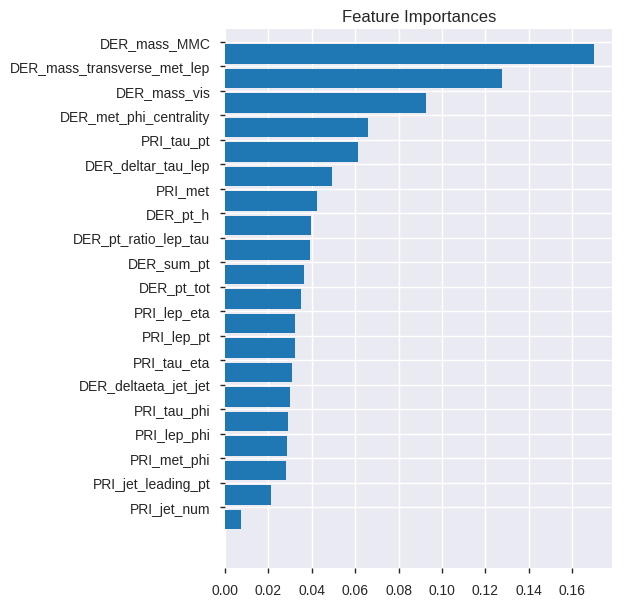

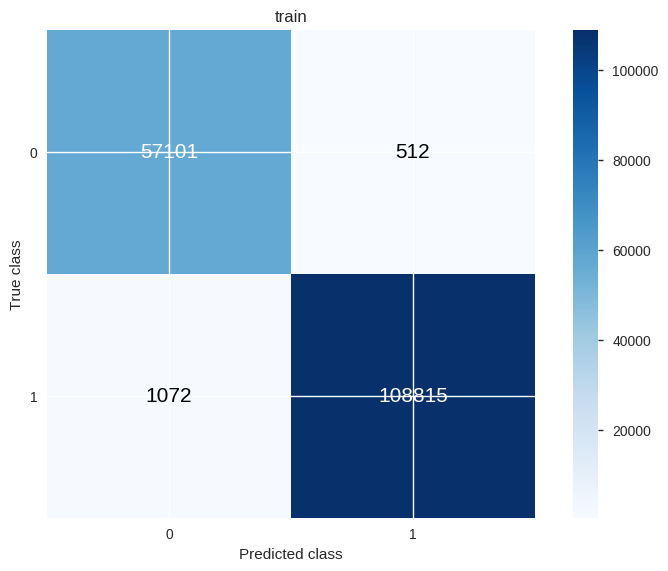

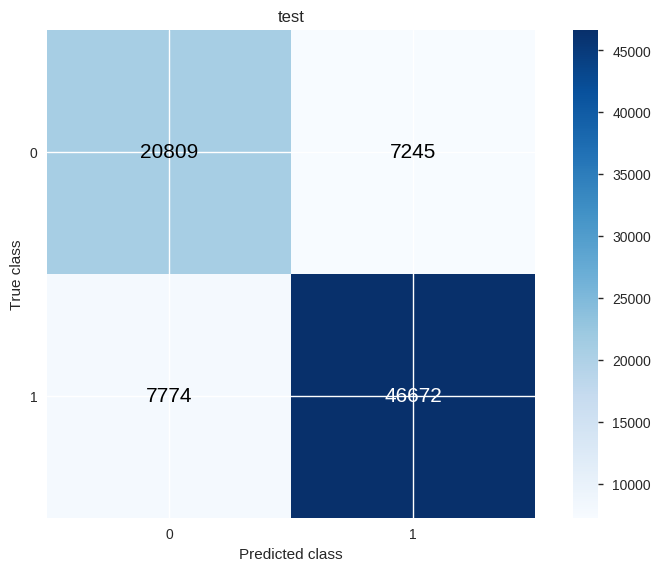

In [23]:
columns_to_ignore = ['Id', 'Prediction'] + profile_report.get_rejected_variables()

X = train_data[[c for c in train_data.columns if c not in columns_to_ignore]]
y = train_data['Prediction'].apply(lambda x: 1 if x == 'b' else 0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

clf = RandomForestClassifier()

clf.fit(X_train, y_train)

y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)

plot_feature_importance(feature_importances=clf.feature_importances_, column_names=X.columns);

plot_confusion_matrix(y_true=y_train, y_pred=y_pred_train, title='train')
plot_confusion_matrix(y_true=y_test, y_pred=y_pred_test, title='test')

display_metrics(y_test=y_test, y_pred_test=y_pred_test, y_train=y_train, y_pred_train=y_pred_train)

# => massive overfitting....

,f1,precision,recall,cohen's kappa,accuracy
train,0.860637,0.809973,0.918061,0.539939,0.804943
test,0.861039,0.810812,0.917900,0.535506,0.804473


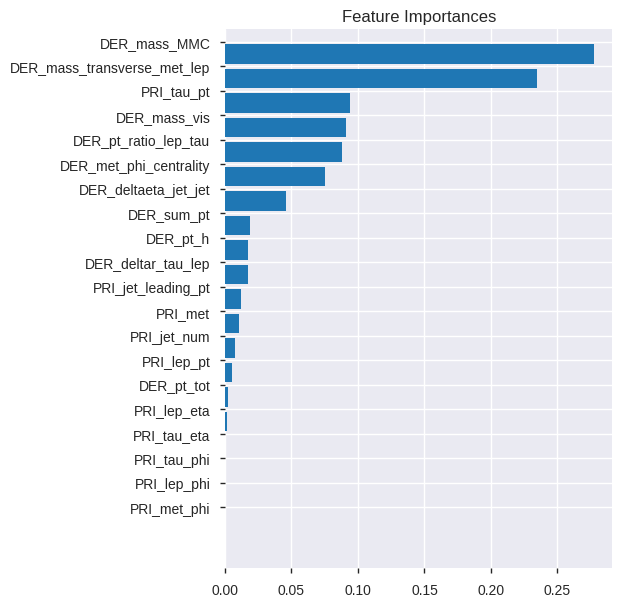

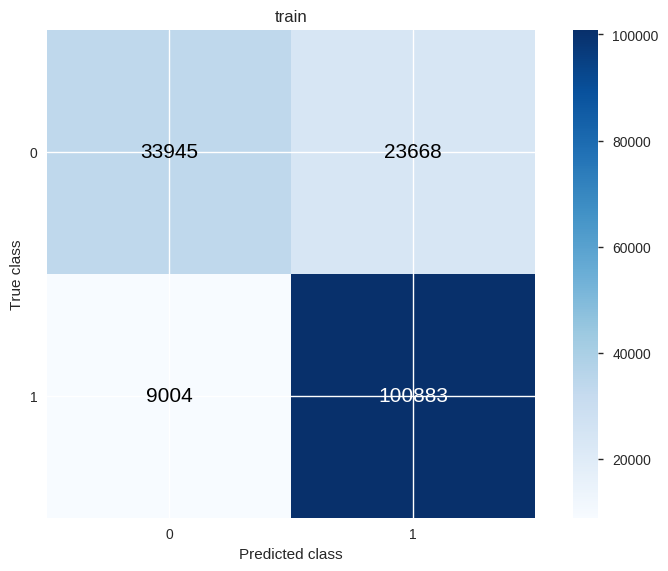

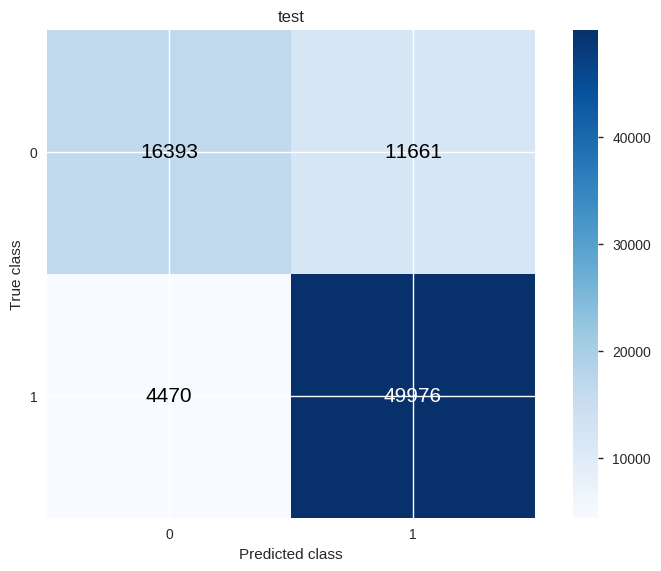

In [34]:
columns_to_ignore = ['Id', 'Prediction'] + profile_report.get_rejected_variables()

X = train_data[[c for c in train_data.columns if c not in columns_to_ignore]]
y = train_data['Prediction'].apply(lambda x: 1 if x == 'b' else 0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

clf = RandomForestClassifier(n_jobs=-1, n_estimators=200, max_depth=3, min_samples_split=10)

clf.fit(X_train, y_train)

y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)

plot_feature_importance(feature_importances=clf.feature_importances_, column_names=X.columns);

plot_confusion_matrix(y_true=y_train, y_pred=y_pred_train, title='train')
plot_confusion_matrix(y_true=y_test, y_pred=y_pred_test, title='test')

display_metrics(y_test=y_test, y_pred_test=y_pred_test, y_train=y_train, y_pred_train=y_pred_train)

,f1,precision,recall,cohen's kappa,accuracy
train,0.855806,0.788549,0.935607,0.499332,0.793164
test,0.855731,0.789744,0.933751,0.493628,0.792218


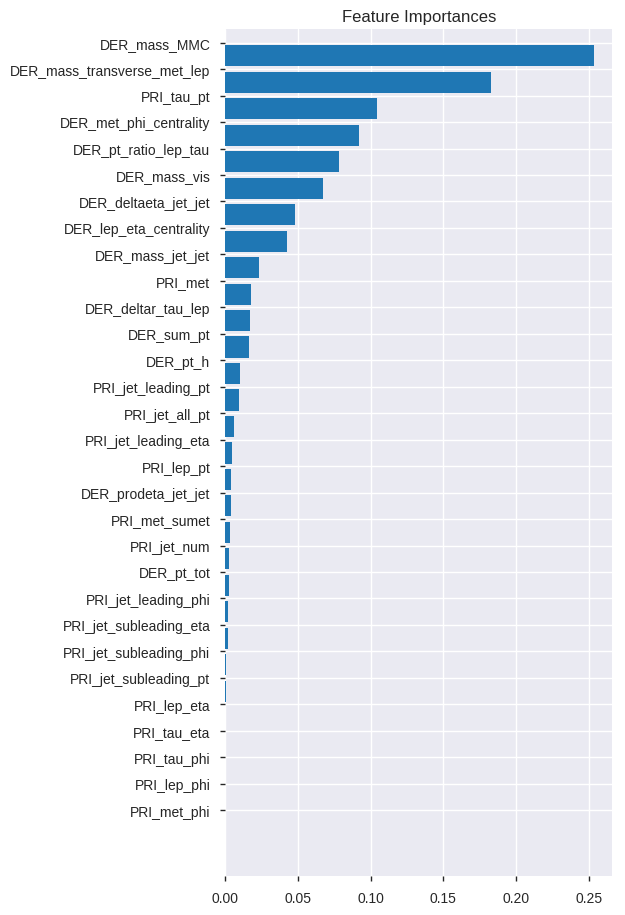

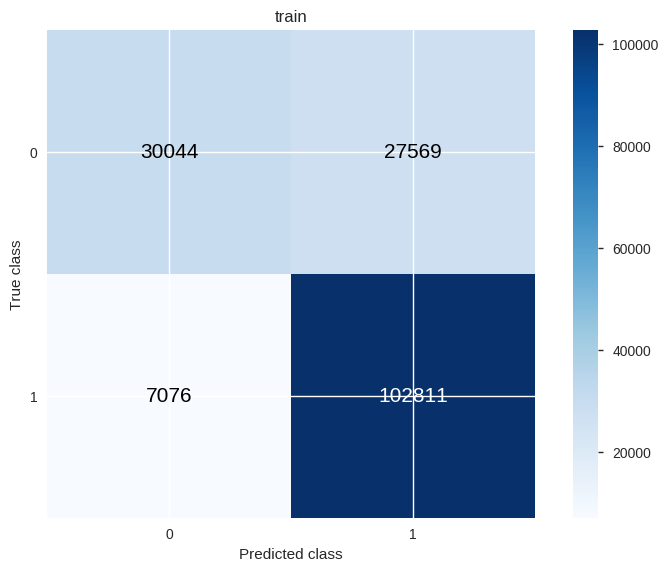

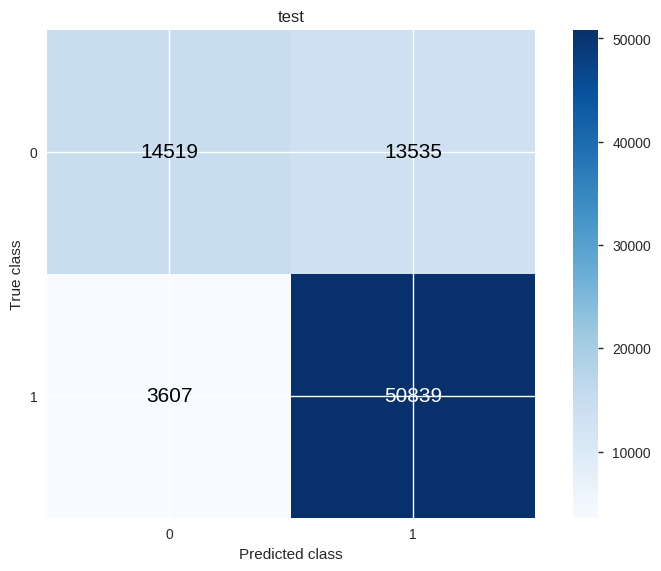

In [36]:
columns_to_ignore = ['Id', 'Prediction']

X = train_data[[c for c in train_data.columns if c not in columns_to_ignore]]
y = train_data['Prediction'].apply(lambda x: 1 if x == 'b' else 0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

clf = RandomForestClassifier(n_jobs=-1, n_estimators=200, max_depth=3)

clf.fit(X_train, y_train)

y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)

plot_feature_importance(feature_importances=clf.feature_importances_, column_names=X.columns);

plot_confusion_matrix(y_true=y_train, y_pred=y_pred_train, title='train')
plot_confusion_matrix(y_true=y_test, y_pred=y_pred_test, title='test')

display_metrics(y_test=y_test, y_pred_test=y_pred_test, y_train=y_train, y_pred_train=y_pred_train)

## Better try

In [33]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

columns_to_ignore = ['Id', 'Prediction'] + profile_report.get_rejected_variables()

X = train_data[[c for c in train_data.columns if c not in columns_to_ignore]]
y = train_data['Prediction'].apply(lambda x: 1 if x == 'b' else 0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

params = [{
            'n_estimators': [10, 100, 200],
            'max_depth': [3,4,5],
          }]

scores = ['accuracy', 'precision', 'recall']

clf = GridSearchCV(RandomForestClassifier(), 
                   params,
                   cv=2, # we have enough data points
                   n_jobs=-1,
                   scoring='accuracy')
clf.fit(X_train, y_train)

print("Best parameters set found on development set:")
print(clf.best_params_)
print("Grid scores on development set:")

means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
print()

print("Detailed classification report:")
y_true, y_pred = y_test, clf.predict(X_test)
print(classification_report(y_true, y_pred))

Best parameters set found on development set:
{'max_depth': 5, 'n_estimators': 100}
Grid scores on development set:
0.796 (+/-0.004) for {'max_depth': 3, 'n_estimators': 10}
0.797 (+/-0.001) for {'max_depth': 3, 'n_estimators': 100}
0.800 (+/-0.001) for {'max_depth': 3, 'n_estimators': 200}
0.799 (+/-0.001) for {'max_depth': 4, 'n_estimators': 10}
0.812 (+/-0.003) for {'max_depth': 4, 'n_estimators': 100}
0.811 (+/-0.001) for {'max_depth': 4, 'n_estimators': 200}
0.811 (+/-0.004) for {'max_depth': 5, 'n_estimators': 10}
0.816 (+/-0.001) for {'max_depth': 5, 'n_estimators': 100}
0.816 (+/-0.002) for {'max_depth': 5, 'n_estimators': 200}

Detailed classification report:
             precision    recall  f1-score   support

          0       0.77      0.66      0.71     28054
          1       0.84      0.90      0.87     54446

avg / total       0.81      0.82      0.81     82500



In [ ]:
plot_feature_importance(feature_importances=clf.feature_importances_, column_names=X.columns);

plot_confusion_matrix(y_true=y_train, y_pred=y_pred_train, title='train')
plot_confusion_matrix(y_true=y_test, y_pred=y_pred_test, title='test')

display_metrics(y_test=y_test, y_pred_test=y_pred_test, y_train=y_train, y_pred_train=y_pred_train)